# 2-2. 归一化

## 1. 背景

在前面的教程中，我们从数据集中删除了低质量的细胞，包括计数较差以及双细胞，并将数据存放在anndata文件中。由于单细胞测序技术的限制，我们在样本中获得RNA的时候，经过了分子捕获，逆转录还有测序。这些步骤会影响同一种细胞的细胞间的测序计数深度的变异性，故单细胞测序数据中的细胞间差异可能会包含了这部分测序误差，等价于计数矩阵中包含了变化很大的方差项。但在目前的统计方法中，绝大部分模型都预先假定了数据具有相同的方差结构。


<div class="admonition warning">
  <p class="admonition-title">伽马-泊松分布</p>
  <p>
   从理论上和经验上建立的 UMI 数据模型是 Gamma-Poisson 分布，即$Var[Y] = \mu + \alpha \mu^2$，其中$\mu$代表UMI平均值，$\alpha$代表细胞UMI的过度离散值。若 $\alpha=0$ 时，意味着此时UMI的分布为泊松分布。
  </p>
</div>

“归一化”的预处理步骤旨在通过将“UMI的方差”缩放到指定范围，来调整数据集中的原始UMI计数以实现模型建模。而在真实的单细胞分析中，有不同的归一化方法以解决不同的分析问题。但经验发现，移位对数在大部分数据中的表现良好，这在2023年4月的Nature Method上的基准测试中有提到。


本章将向读者介绍两种不同的归一化技术：移位对数变换和皮尔逊残差的解析近似。移位对数有利于稳定方差，以利于后续降维和差异表达基因的识别。皮尔森近似残差可以保留生物学差异，并鉴定稀有细胞类型。

我们首先导入我们所需要的Python包，以及上一个教程分析所得到的anndata文件。


In [2]:
import omicverse as ov
import scanpy as sc

ov.utils.ov_plot_set()

In [3]:
adata = sc.read(
    filename="s4d8_quality_control.h5ad",
    backup_url="https://figshare.com/ndownloader/files/40014331",
)

try downloading from url
https://figshare.com/ndownloader/files/40014331
... this may take a while but only happens once


  0%|          | 0.00/501M [00:00<?, ?B/s]

我们首先检查原始计数UMI的分布，一般在后续的分析中我们会忽略这一步，但对该分布的认识有利于我们理解归一化的意义。

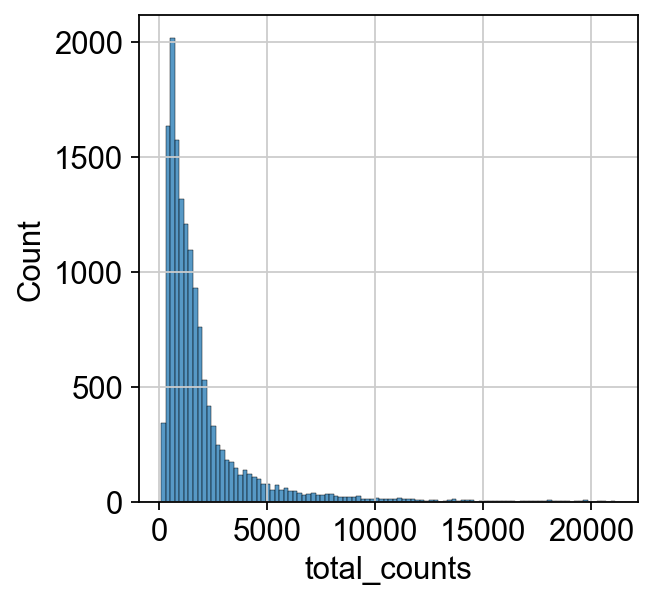

In [3]:
import seaborn as sns
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False)

## 2. 移位对数

我们将介绍的第一个归一化方法是基于delta方法的移位对数。Delta方法应用非线性函数$f(Y)$，使得原始计数 $Y$ 中的差异更加相似。

我们定义非线性函数$f(Y)$的变换如下：

$$f(y) = \log(\frac{y}{s}+y_0)$$ 

其中$y$是原始的计数，$s$是尺寸因子，$y_0$是伪计数。我们为每一个细胞确定自己的尺寸因子，以满足同时考虑采样效果和不同细胞尺寸的变换。细胞的尺寸因子可以计算为：

$$s_c = \frac{\sum_g y_{gc}}{L}$$ 

其中 $g$代表不同的基因，$L$代表基因的计数总和。确定尺寸因子的方法有很多，在`scanpy`中，我们默认使用原始计数深度的中位数来计算，而在`seruat`中使用固定值$L=10^4$，而在`omicverse`的预处理中，我们将$L$设定为$50*10^4$。不同的值会使得过度离散值 $\alpha$的不同。

<div class="admonition warning">
  <p class="admonition-title">过度离散值 $\alpha$</p>
  <p>
   过度离散值 $\alpha$描述了数据集中存在着比期望更大的变异性。
  </p>
</div>

移位对数是一种快速归一化技术，优于其他揭示数据集潜在结构的方法（特别是在进行主成分分析时），并且有利于方差的稳定性，以进行后续的降维和差异表达基因的识别。我们现在将检查如何将此归一化方法应用于我们的数据集。我们可以使用`pp.normalized_total`来使用 scanpy 调用移位对数。并且我们设置`target_sum=None`,`inplace=False`来探索两种不同的归一化技术。

In [4]:
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
# log1p transform
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

normalizing counts per cell
    finished (0:00:00)


我们使用`hist`图来对比归一化前后的计数变化

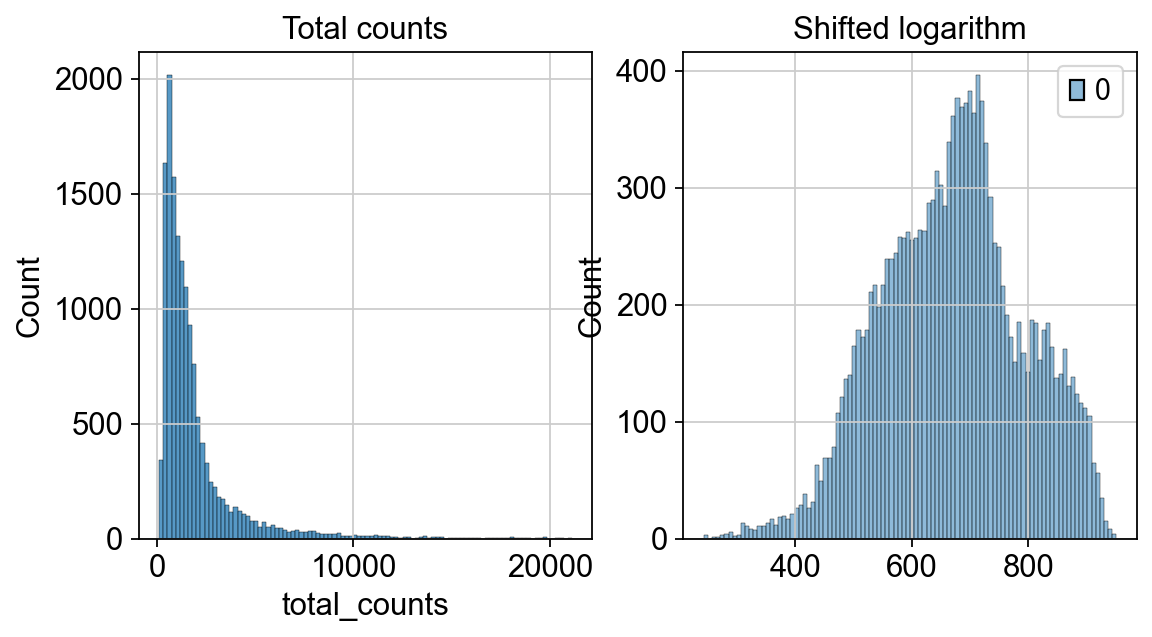

In [6]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

我们发现nUMI的最大值在1000左右，经过移位对数化后，并且移位对数化后的nUMI的分布近似正态分布。

## 3. 皮尔森近似残差

我们观察到，scRNA-seq数据中的细胞间变异包括了生物异质性以及技术效应。而移位计数并不能很好的排除两种不同变异来源的混淆误差。皮尔森近似残差利用了“正则化负二项式回归”的皮尔森残差来计算数据中潜在的技术噪音，将计数深度添加为广义线性模型中的协变量，而在不同的归一化方法的测试中，皮尔森残差法可以消除计数效应带来的误差，并且保留了数据集中的细胞异质性。

此外，皮尔森残差法不需要进行启发式步骤，如伪计数加法/对数变化，该方法的输出就是归一化后的值，包括了正值和负值。细胞和基因的负残差表明与基因的平均表达和细胞测序深度相比，观察到的计数少于预期。正残差分别表示计数越多。解析 Pearon 残差在 scanpy 中实现，可以直接在原始计数矩阵上计算。

In [7]:
from scipy.sparse import csr_matrix
analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(adata, inplace=False)
adata.layers["analytic_pearson_residuals"] = csr_matrix(analytic_pearson["X"])

computing analytic Pearson residuals on adata.X
    finished (0:00:15)


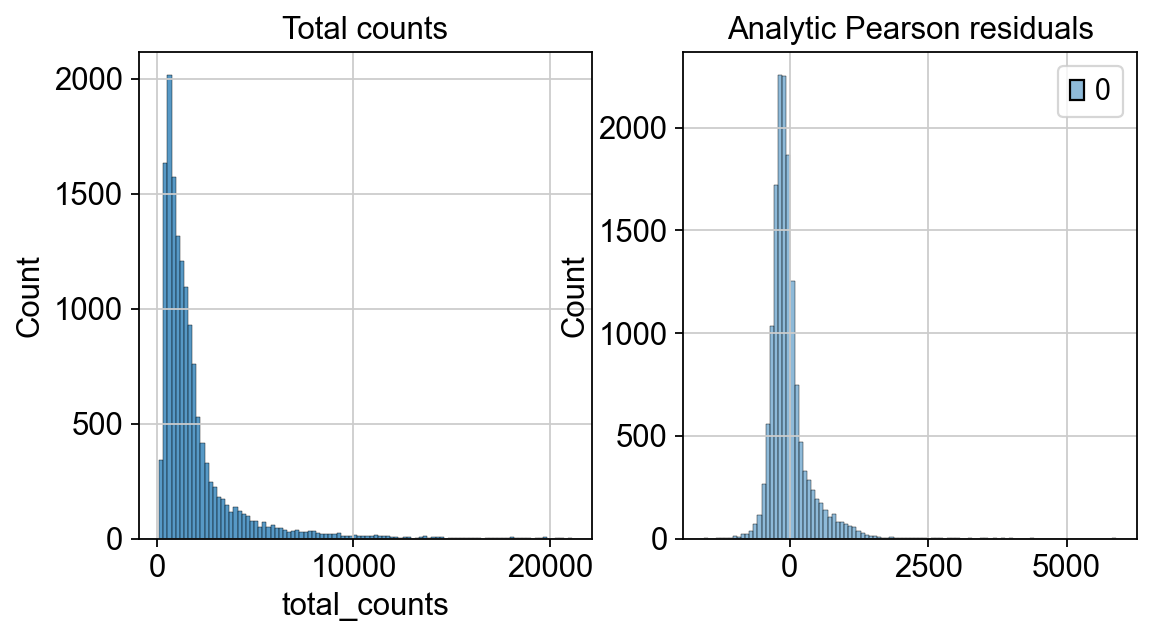

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(
    adata.layers["analytic_pearson_residuals"].sum(1), bins=100, kde=False, ax=axes[1]
)
axes[1].set_title("Analytic Pearson residuals")
plt.show()

如果我们设置`inplace=False`时，我们归一化的计数矩阵会取代原anndata文件中的计数矩阵，即更改`adata.X`的内容。

## 4. 一键式归一化

我们在`omicverse`中提供了预处理函数`pp.preprocess`，该方法可直接计算移位对数或皮尔森残差，方法内同时包括了基于移位对数/皮尔森残差的高可变基因的选择方法，高可变基因会在下一节的教程中进行讲解。

此外，我们`omicverse`的归一化方法还提供了稳定基因的识别与过滤。

### 4.1 移位对数

在`omicverse`中，我们设置`mode='shiftlog|pearson'`即可完成移位对数的计算，一般来说，默认的`target_sum=50*1e4`，同时高可变基因定义为前2000个,需要注意的是，当`omicverse`的版本小于`1.4.13`时，mode的参数只能设置为`scanpy`或`pearson`，`scanpy`与`shiftlog`的意义是相同的

In [4]:
adata_log=ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=2000,)
adata_log

Begin log-normalization, HVGs identification
After filtration, 20171/20171 genes are kept. Among 20171 genes, 20171 genes are robust.
End of log-normalization, HVGs identification.
Begin size normalization and pegasus batch aware HVGs selection or Perason residuals workflow
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
[]
    finished (0:00:00)
2000 highly variable features have been selected.
End of size normalization and pegasus batch aware HVGs selection or Perason residuals workflow.


AnnData object with n_obs × n_vars = 14814 × 20171
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'scDblFinder_score', 'scDblFinder_class'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'percent_cells', 'robust', 'highly_variable_features', 'mean', 'var', 'hvf_loess', 'hvf_rank'
    uns: 'log1p'
    layers: 'counts', 'soupX_counts'

### 4.2 皮尔森近似残差

我们也可以设置`mode='pearson|pearson'`来完成皮尔森近似残差的计算，此时我们不需要输入`target_sum`，需要注意的是，当`omicverse`的版本小于`1.4.13`时，mode的参数只能设置为`scanpy`或`pearson`

In [5]:
adata_pearson=ov.pp.preprocess(adata,mode='pearson|pearson',n_HVGs=2000,)
adata_pearson

Begin log-normalization, HVGs identification
After filtration, 20171/20171 genes are kept. Among 20171 genes, 20171 genes are robust.
End of log-normalization, HVGs identification.
Begin size normalization and pegasus batch aware HVGs selection or Perason residuals workflow
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
computing analytic Pearson residuals on adata.X
    finished (0:00:04)
End of size normalization and pegasus batch aware HVGs selection or Perason residuals workflow.


AnnData object with n_obs × n_vars = 14814 × 20171
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'scDblFinder_score', 'scDblFinder_class'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'hvg', 'pearson_residuals_normalization'
    layers: 'counts', 'soupX_counts'

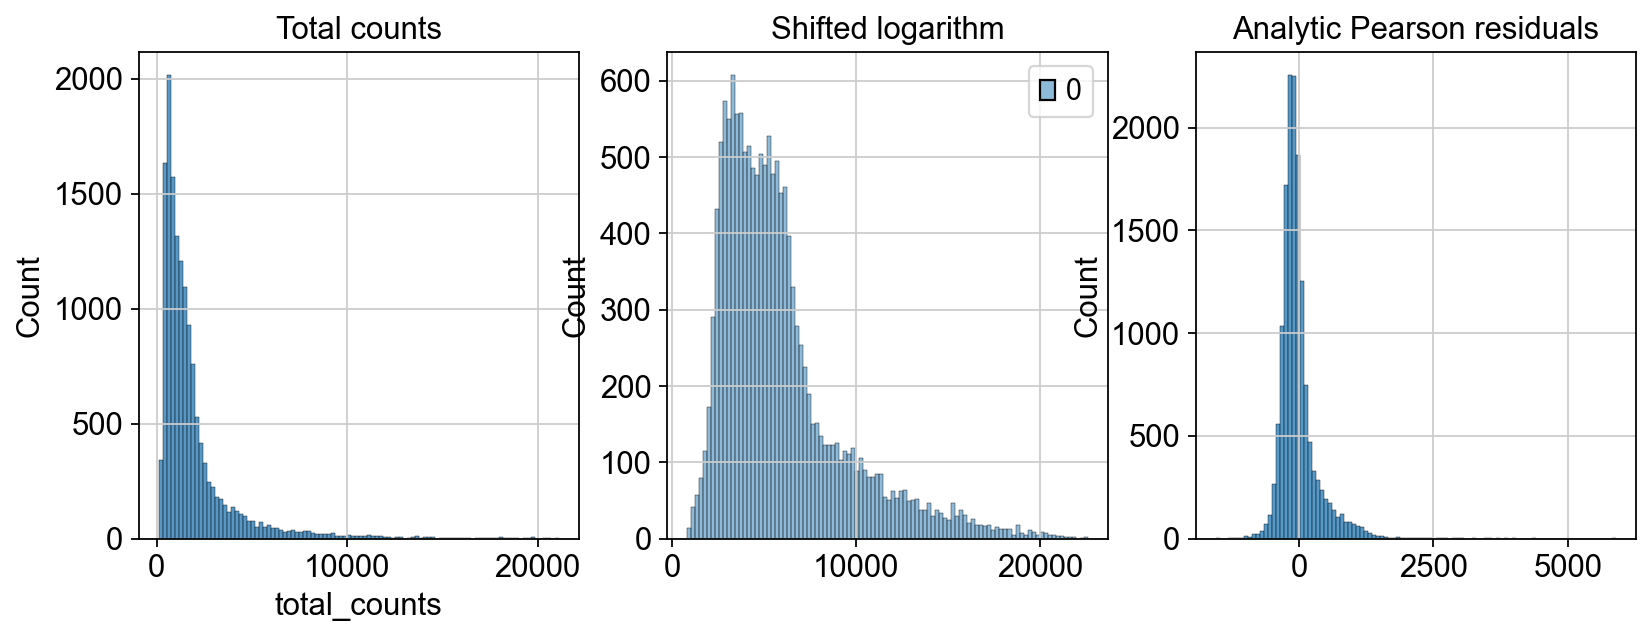

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")

p2 = sns.histplot(
    adata_log.X.sum(1), bins=100, kde=False, ax=axes[1]
)
axes[1].set_title("Shifted logarithm")

p3 = sns.histplot(
    adata_pearson.X.sum(1), bins=100, kde=False, ax=axes[2]
)
axes[2].set_title("Analytic Pearson residuals")
plt.show()

## 5. 思考

- 我们在进行移位对数分析的时候，`sc.pp.normalize_total(adata, target_sum=None, inplace=False)`中的`target_sum`使用了默认值，在`seurat`中默认值是10,000，在一些教程中设定为1,000,000，我们虽然对这个值的意义进行了简单介绍，但你认为不同的值背后的含义是什么？
- 我们为什么会使用皮尔森残差来计算归一化值，相对于移位对数而言有什么更好的地方？
- 你可以找出别的归一化方法，并比较其与移位对数，皮尔森残差的好坏吗？

以上，就是本章所要介绍的归一化内容，通过benchmark的测试，我们发现移位对数适用于大多数任务。但是如果我们的分析目标是寻找稀有细胞的时候，可以考虑采用皮尔森残差法来进行归一化。